# Experiment  0: ToM Overall Model Performance


In [1]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [3]:
def plot_goal_distribution(goal_distribution):
    """
    Plot the goal distribution as a bar plot.

    Parameters
    ----------
    goal_distribution : dict
        Dictionary mapping candidate goal IDs to probability values.
    """
    # Extract goal IDs and probabilities, converting to floats if needed.
    goals = list(goal_distribution.keys())
    probs = [float(goal_distribution[g]) for g in goals]
    
    # Create the bar plot.
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(goals)), probs, tick_label=[str(g) for g in goals])
    plt.xlabel("Candidate Goal IDs")
    plt.ylabel("Probability")
    plt.title("Posterior Distribution over Candidate Goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [128]:
def visualize_map(campus,
                  path=None,
                  goal_nodes=None,
                  ax=None):
    """
    Visualize the campus map, plus optional trajectory, start, waypoint, and goal nodes.
    
    Arguments:
      campus         an object with:
                        - campus.G           : a networkx graph
                        - campus.node_coords : dict[node] -> (x, y) coordinates
                        - campus.buildings   : a GeoDataFrame of building footprints (or None)
      path           list of node‐IDs, the agent’s trajectory to draw (in order)
      start_nodes    list of node‐IDs to mark as start(s)
      waypoint       single node‐ID to mark as an intermediate waypoint
      goal_nodes     list of node‐IDs to mark as goal(s)
      ax             optional matplotlib Axes onto which to draw
      
    Returns:
      fig, ax        the figure & axis
    """
    # 1) draw the base map
    if ax is None:
        fig, ax = ox.plot_graph(campus.G,
                                figsize=(15,15),
                                node_size=5,
                                edge_color="#999999",
                                show=False,
                                close=False)
    else:
        fig = ax.figure
        ox.plot_graph(campus.G,
                      ax=ax,
                      node_size=5,
                      edge_color="#999999",
                      show=False)
    
    # 2) overlay buildings if you have them
    if getattr(campus, "buildings", None) is not None:
        campus.buildings.plot(ax=ax,
                              color="#bbbbbb",
                              alpha=0.7,
                              edgecolor="#444444")
    
    # 3) draw the agent’s path
    if path is not None and len(path) > 1:
        coords = [campus.node_coords[n] for n in path]
        xs, ys = zip(*coords)
        ax.plot(xs, ys,
                linestyle='-',
                linewidth=3.0,
                color='lightblue',
                alpha=0.8,
                zorder=3,
                label="Trajectory")
        # and mark the actual visited nodes
        ax.scatter(xs, ys,
                   c='C0',
                   s=30,
                   zorder=4)
    
    # 6) mark goal nodes
    if goal_nodes:
        goal_coords = [campus.node_coords[n] for n in goal_nodes]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="yellow",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Goal")
    
    # 7) finalize
    ax.legend(loc="upper right")
    ax.set_title("UCSD Campus Environment")
    ax.set_axis_off()
    fig.tight_layout()
    return fig, ax

In [5]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color


## Steps  
1. Create the UCSD campus world
2. Create n agents each with a specific distribution over the goals
3. Run m epsiodes where each agent chooses a goal and performs a single path to that goal
4. Use this data as training set

## Step 1: Create the Map

In [6]:
# Create a run manager
run_manager = RunManager('visuals')
run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Started new simulation run #24
All visualizations will be saved to: /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_24_20250501_130945
Loading map data for University of California, San Diego, La Jolla, CA, USA...
Environment loaded with 3108 nodes and 8646 edges


## Step 2: Create N Agents

In [38]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [39]:
# Create n agents
agents = []
n = 100
for i in range(n):
    agents.append(AgentFactory.create_agent("shortest"))
    agents[i].id = i

In [40]:
n_goals = len(goals)
ag_alpha = np.random.normal(1, 0.2, size=n_goals)

for agent in agents: # Set each agent's goal distribution
    agent.goal_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]
    agent.environment = campus

In [41]:
def new_episode(agents):

    # Set the goal and start nodes
    for agent in agents:
        agent.path = [] # Clear the old path
        agent.goal_node = int(np.random.choice(goals, size=1, p=agent.goal_distribution)[0])

        while True:
            start_node = campus.get_random_node()
            try:
                path = nx.shortest_path(campus.G_undirected, 
                                       source=start_node, 
                                       target=agent.goal_node, 
                                       weight='length')
                if len(path) >15:  # Make sure path is non-trivial
                    break
            except:
                continue
        agent.start_node = start_node
        agent.current_node = start_node

    return 

In [129]:
# Save the agents 
import pickle

# suppose `agents` is your list of Agent instances
with open('agents.pkl', 'wb') as f:
    pickle.dump(agents, f)

## Step 3: Perform Episodes and Data Collection

In [42]:
import json

In [43]:
""" Already ran once. Data is saved in /data"""

path_data = {}
goal_data = {}
m = 100
for episode in range(m):
    new_episode(agents)
    episode_path_data = {}
    episode_goal_data = {}
    for agent in agents:
        agent.plan_path()
        episode_path_data[agent.id] = agent.path
        episode_goal_data[agent.id] = agent.goal_node
    # Save the data from each episode
    path_data[episode] = episode_path_data
    goal_data[episode] = episode_goal_data

with open("./data/path_data.json", "w") as file:
    json.dump(path_data, file, indent=4)

with open("./data/goal_data.json", "w") as file:
    json.dump(goal_data, file, indent=4)



### Load existing data

In [44]:
with open("./data/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./data/goal_data.json", 'r') as file:
    goal_data = json.load(file)

In [45]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [46]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 4: Fit the BToM Model for Each Agent  
There should again be a dict of dict for posteriors. The first key will be for the episode, the second key will be the agent, and the value of this will be a list of dicts for the posteriors. 

In [47]:
# Import BToM baseline
from real_world_src.models.btom import BToM

In [48]:
btom = BToM(campus, agents, goals)

Computing shortest paths...
Done


In [93]:
# Calculate all the posteriors using the first 30 episode
posteriors_data = {}

for episode in range(len(goal_data)):
    posteriors_data[episode] = {}
    for agent in agents:
        posteriors_data[episode][agent.id] = btom.update_agent_posterior_over_path(agent, path_data[episode][agent.id])
    # Reset the posteriors for new episode
    btom.reset_posteriors()

## Step 5: Visualizing Performance for Experiment 0  
We want to visualize the average brier score across all agents for all epsiodes. That is, calculate the brier score for every path and then take the average. Plot this as a line.

In [127]:
def brier_score(true_goal, p_dist):
    """
    Multi-class Brier score given a dict goal→prob.
    """
    score = 0.0
    for g, p in p_dist.items():
        y = 1.0 if g == true_goal else 0.0
        score += (p - y) ** 2
    return float(score)


def brier_along_path(path, true_goal, posteriors_by_step, goals):
    """
    Compute Brier scores at 0%, 10%, …, 100% of the path.
    
    Parameters
    ----------
    path : list
        The sequence of states (or state-action tuples).
    true_goal : hashable
        The ground-truth goal for this trajectory.
    posteriors_by_step : dict[int, dict] or list[dict]
        Either
          * a dict mapping step index 1..n → posterior dict, OR
          * a list of posterior dicts in step-order (len = n).
        Each posterior dict maps each goal → P(goal | trajectory up to that step).
    
    Returns
    -------
    dict[float, float]
        Mapping fraction → Brier score.
    """
    n = len(path) - 1
    if n < 1:
        raise ValueError("Path must have at least 2 states to define transitions")

    # uniform prior for t=0
    uniform = {g: 1.0/len(goals) for g in goals}

    results = []
    for frac in np.linspace(0, 1, 11):  # 0.0,0.1,...,1.0
        t = int(np.floor(frac * n))
        if t == 0:
            p_dist = uniform
        else:
            p_dist = posteriors_by_step[t-1]
        results.append(brier_score(true_goal, p_dist))

    return results

In [102]:
scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))


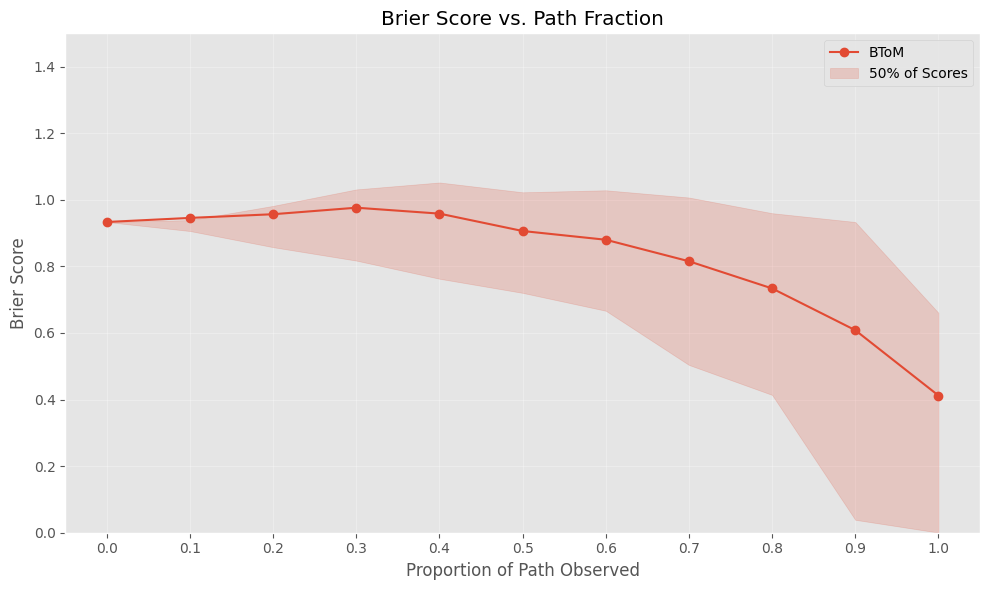

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(scores)  # shape (N, 11)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_scores = arr.mean(axis=0)

# Compute percentiles for a 95% *prediction* interval
lower = np.percentile(arr, 25, axis=0)
upper = np.percentile(arr, 75, axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_scores, '-o', label='BToM')
plt.fill_between(props, lower, upper,
                 color='C0', alpha=0.2,
                 label='50% of Scores')
plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 1.5)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()